## Polynomial regression with PyTorch


In [899]:
import matplotlib.pyplot as plt 
import numpy as np
my_seed = 1
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
dtype = torch.FloatTensor

In [900]:
def g(x):
    # the true polynomial g(x)
    return 0.1 * (x-2) ** 3 + x ** 2 - 8.0 * x - 1.0

def generate(N):
    # dataset generation
    x = np.random.rand(N) * 40.0 - 20.0
    y = g(x) + 50 * np.random.randn(N)
    
    return x.reshape(N, 1), y.reshape(N, 1)

N = 50 # number of samples
x_train, y_train = generate(N) # dataset

print(x_train.shape)
print(y_train.shape)

(50, 1)
(50, 1)


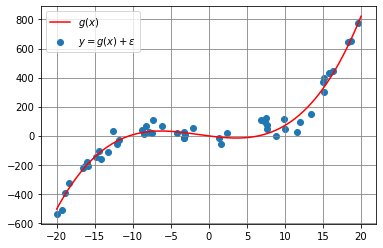

In [901]:
xs = np.linspace(-20, 20, num=1000)
plt.plot(xs, g(xs), c="r", label="$g(x)$")
plt.scatter(x_train, y_train, label="$y = g(x) + \epsilon$")
plt.legend(loc='upper left')
plt.grid(color="grey")
plt.show()

In [902]:
class MyNN(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNN, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim) 
        self.act_fn = nn.Identity()
        
    def forward(self, x):
        
        x_ext = torch.concat((x.pow(3),x.pow(2),x),1) #we take x,x^2 and x^3 in features (we could take x^0 but we assume f(0)=0)
        return self.fc(self.act_fn(x_ext))


In [903]:
def train(x, y, my_nn, loss_fn, optimizer, learning_rate, num_epoch):
    
    # We turn our model in train mode. Some layers that we do not use here 
    # behave differently on train and eval mode. 
    my_nn.train() 
    
    # We define the optimizer
    optimizer = optimizer(my_nn.parameters(), lr=learning_rate)
    
    train_loss = []
    
    for epoch in range(num_epoch):

        my_nn.zero_grad() # reset the stored gradients for the parameters of the neural network

        y_hat = my_nn(x) # do the forward pass

        loss = loss_fn(y_hat, y) # compute the loss
        # this is equivalent to:
        # loss = (y_pred - y_train_tensor).pow(2).mean()    

        loss.backward() # do the backward pass

        optimizer.step() # do a SGD step
        ## this is equivalent to:
        # for p in my_nn1.parameters():
        #    p.data = p.data - learning_rate*p.grad.data

        train_loss.append(loss.item()) # store the loss
    
    return train_loss

In [904]:
loss_fn = nn.MSELoss(reduction='mean')

In [905]:
optimizer = torch.optim.SGD

In [906]:
# convert input/output data to tensors
x_train_tensor = torch.from_numpy(x_train).type(dtype)
y_train_tensor = torch.from_numpy(y_train).type(dtype)

my_nn = MyNN(3,1) 

train_loss = train(x=x_train_tensor, 
                   y=y_train_tensor, 
                   my_nn=my_nn, 
                   loss_fn=loss_fn, 
                   optimizer=optimizer, 
                   learning_rate=1e-8, 
                   num_epoch=40)

In [907]:
def plot_results(loss, my_nn): #function to plot loss curve and learned function curve 
    
    # plot loss
    plt.figure()
    plt.plot(loss)
    plt.title('loss function')
    plt.xlabel('epochs')
    
    # plot learned function
    xs = np.linspace(-20, 20, num=1000)
    xs_tensor = torch.from_numpy(xs).type(dtype).unsqueeze(1)
    with torch.no_grad():
        y_pred = my_nn(xs_tensor).numpy()

    plt.figure()
    plt.plot(xs, g(xs), c="r", label="$g(x)$")
    plt.scatter(x_train, y_train, label="$y = g(x) + \epsilon$")
    plt.plot(xs, y_pred, c="k", label="$\hat{g}(x)$")
    plt.legend(loc='upper left')
    plt.grid(color="grey")
    plt.show()

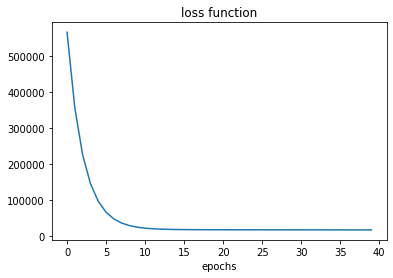

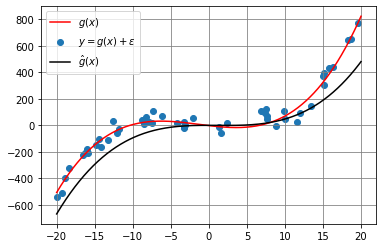

In [908]:
plot_results(train_loss, my_nn)

## Polynomial fit with a multi-layer perceptron

The previous model is polynomial with respect to the input, but **linear** with respect to the model parameters. We could actually fit a standard multilayer perceptron on our training samples. The resulting model would be **non-linear** with respect to the model parameters. This is what we do below. 

In [909]:
class MySecondNN(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MySecondNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU() # we use Rectified Linear Units activations

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        return x


In [910]:
my_nn2 = MySecondNN(1, 1, 50)

# standard gradient descent gives poor results here, so we choose another optimization method called Adam
optimizer = torch.optim.Adam 

train_loss = train(x=x_train_tensor, 
                   y=y_train_tensor, 
                   my_nn=my_nn2, 
                   loss_fn=loss_fn, 
                   optimizer=optimizer, 
                   learning_rate=1e-3, 
                   num_epoch=10000)

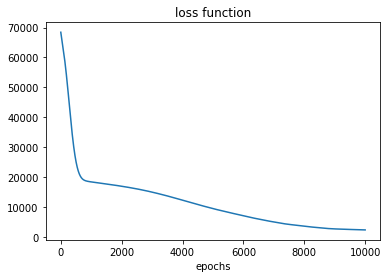

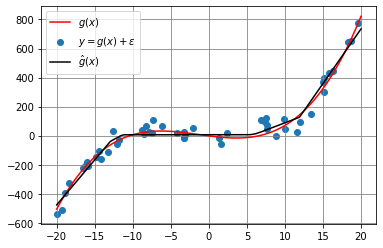

In [911]:
plot_results(train_loss, my_nn2)